#### I. Use k-Means Clustering to Group Employees into Clusters

**Initiate new Spark session.**

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Employee_Attrition_Part_5').getOrCreate()

**Import numpy, pandas, and data visualization libraries.**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Import churn modeling CSV file into PySpark dataframe called churn_model2.**

In [7]:
churn_model2 = spark.read.csv('/FileStore/tables/churn_modeling_data.csv', inferSchema=True, header=True)

**Check number of rows and columns in churn_model2 dataframe.**

In [9]:
print(churn_model2.count(), len(churn_model2.columns))

1470 11

**View structure of churn_model2 dataframe.**

In [11]:
churn_model2.printSchema()

root
-- Churn: integer (nullable = true)
-- Age: integer (nullable = true)
-- DistanceFromHome: integer (nullable = true)
-- EnvironmentSatisfaction: integer (nullable = true)
-- JobInvolvement: integer (nullable = true)
-- MonthlyIncome: integer (nullable = true)
-- StockOptionLevel: integer (nullable = true)
-- Sales_Rep: integer (nullable = true)
-- Single: integer (nullable = true)
-- BusTravLevel: integer (nullable = true)
-- Overtime_Dum: integer (nullable = true)

**View first five rows of churn_model2 dataframe.**

In [13]:
display(churn_model2.head(5))

Churn,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,MonthlyIncome,StockOptionLevel,Sales_Rep,Single,BusTravLevel,Overtime_Dum
1,41,1,1,2,5993,0,0,1,1,1
0,49,8,2,1,5130,1,0,0,2,0
1,37,2,3,1,2090,0,0,1,1,1
0,33,3,3,2,2909,0,0,0,2,1
0,27,2,0,2,3468,1,0,0,1,0


**Drop Churn target variable and include only predictor features in churn_model2 dataframe for k-means clustering.**

In [15]:
churn_pred_feat = churn_model2.drop(*['Churn'])

**Convert predictor features into vector column using VectorAssembler.**

In [17]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [18]:
assembler = VectorAssembler(inputCols=['Age', 'DistanceFromHome', 'EnvironmentSatisfaction', 'JobInvolvement', 'MonthlyIncome', 'StockOptionLevel', 'Sales_Rep', 'Single', 'BusTravLevel', 'Overtime_Dum'], outputCol='features')

In [19]:
churn_pred_feat_vect = assembler.transform(churn_pred_feat)
display(churn_pred_feat_vect.head(5))

Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,MonthlyIncome,StockOptionLevel,Sales_Rep,Single,BusTravLevel,Overtime_Dum,features
41,1,1,2,5993,0,0,1,1,1,"List(1, 10, List(), List(41.0, 1.0, 1.0, 2.0, 5993.0, 0.0, 0.0, 1.0, 1.0, 1.0))"
49,8,2,1,5130,1,0,0,2,0,"List(1, 10, List(), List(49.0, 8.0, 2.0, 1.0, 5130.0, 1.0, 0.0, 0.0, 2.0, 0.0))"
37,2,3,1,2090,0,0,1,1,1,"List(1, 10, List(), List(37.0, 2.0, 3.0, 1.0, 2090.0, 0.0, 0.0, 1.0, 1.0, 1.0))"
33,3,3,2,2909,0,0,0,2,1,"List(1, 10, List(), List(33.0, 3.0, 3.0, 2.0, 2909.0, 0.0, 0.0, 0.0, 2.0, 1.0))"
27,2,0,2,3468,1,0,0,1,0,"List(1, 10, List(), List(27.0, 2.0, 0.0, 2.0, 3468.0, 1.0, 0.0, 0.0, 1.0, 0.0))"


**Center and scale all predictor features.**

In [21]:
from pyspark.ml.feature import StandardScaler

In [22]:
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
scaler_model = scaler.fit(churn_pred_feat_vect)
churn_pred_feat_scaled = scaler_model.transform(churn_pred_feat_vect)

**Using scaled predictor features, determine how many clusters will yield the highest silhouette score and produce the lowest inertia (which is sum of squared error or distance between a data point and the cluster centroid).**

In [24]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [25]:
clus_eval = ClusteringEvaluator()

In [26]:
k_range = range(2, 11)

In [27]:
sil_scores = []

In [28]:
inertia_values = []

In [29]:
for k_value in k_range:
  kmc1 = KMeans(featuresCol='scaled_features', k=k_value).setSeed(123)
  kmc1_model = kmc1.fit(churn_pred_feat_scaled)
  inertia_values.append(kmc1_model.computeCost(churn_pred_feat_scaled))
  kmc1_predictions = kmc1_model.transform(churn_pred_feat_scaled)
  sil_scores.append(clus_eval.evaluate(kmc1_predictions))

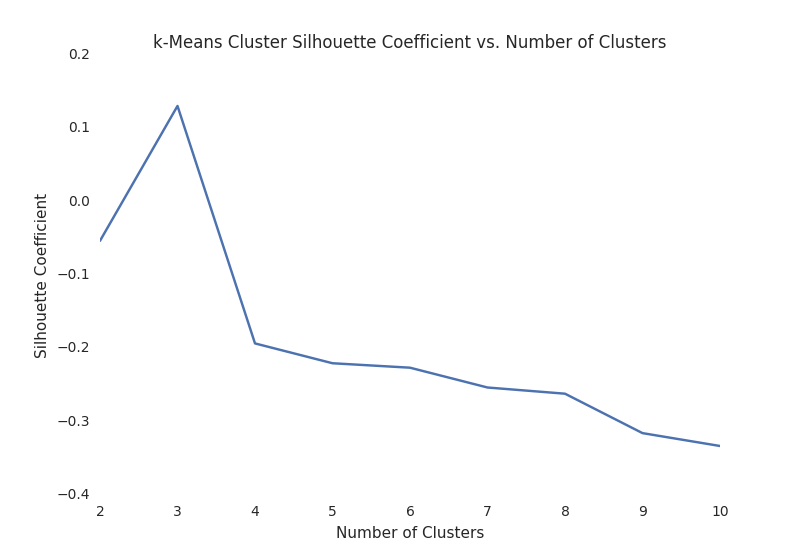

In [30]:
clus_sil_score, ax = plt.subplots()
ax.plot(k_range, sil_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Coefficient')
ax.set_title('k-Means Cluster Silhouette Coefficient vs. Number of Clusters')
display(clus_sil_score)

In [31]:
dict(zip(k_range, sil_scores))

Out[ 20 ]: 
{2: -0.05339519820395932,
 3: 0.13052274927074242,
 4: -0.1932975231466738,
 5: -0.2203365278439531,
 6: -0.22640454950944017,
 7: -0.2534142285461967,
 8: -0.2618607909548427,
 9: -0.3156176700871847,
 10: -0.333179263985305}

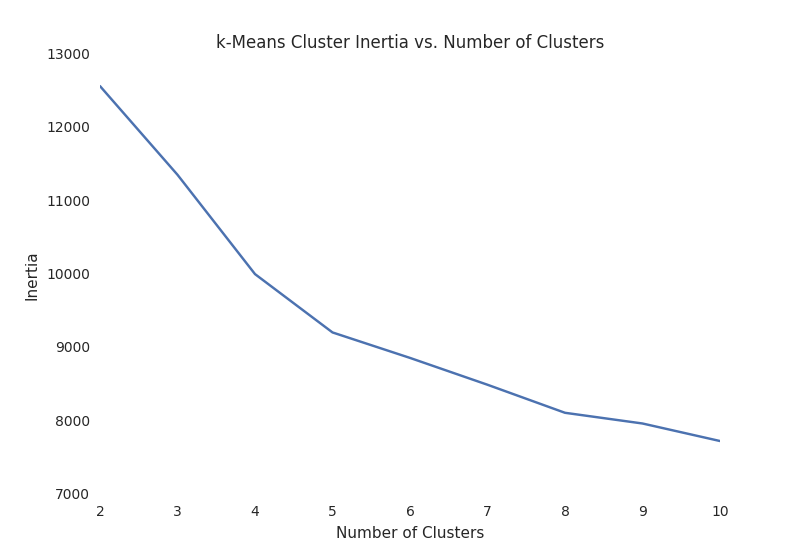

In [32]:
clus_inertias, ax = plt.subplots()
ax.plot(k_range, inertia_values)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
ax.set_title('k-Means Cluster Inertia vs. Number of Clusters')
display(clus_inertias)

In [33]:
dict(zip(k_range, inertia_values))

Out[ 22 ]: 
{2: 12575.875971955697,
 3: 11366.65913206184,
 4: 10012.298230300212,
 5: 9216.848432554125,
 6: 8869.376481685269,
 7: 8503.43906691617,
 8: 8121.02485210504,
 9: 7975.112045996482,
 10: 7736.043697767086}

* The employees in the churn_model2 dataframe can be grouped into 3 clusters using k-means clustering and features for predicting churn. Even though the data points in each cluster are less closely related to the centroid, as indicated by the high inertia value, the clusters overlap each other the least from having the highest silhouette score.

**Assign employees in churn_model2 dataframe into 3 clusters.**

In [36]:
kmc2 = KMeans(featuresCol='scaled_features', k=3).setSeed(123)
kmc2_model = kmc2.fit(churn_pred_feat_scaled)
kmc2_predictions = kmc2_model.transform(churn_pred_feat_scaled)
display(kmc2_predictions.head(5))

Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,MonthlyIncome,StockOptionLevel,Sales_Rep,Single,BusTravLevel,Overtime_Dum,features,scaled_features,prediction
41,1,1,2,5993,0,0,1,1,1,"List(1, 10, List(), List(41.0, 1.0, 1.0, 2.0, 5993.0, 0.0, 0.0, 1.0, 1.0, 1.0))","List(1, 10, List(), List(0.4461985578408614, -1.0105654376999094, -0.6603059658453994, 0.3795429667311688, -0.10831265366490042, -0.9316973236084981, -0.24454176710317263, 1.4581536911459163, -0.16234393198579045, 1.591204032206066))",2
49,8,2,1,5130,1,0,0,2,0,"List(1, 10, List(), List(49.0, 8.0, 2.0, 1.0, 5130.0, 1.0, 0.0, 0.0, 2.0, 0.0))","List(1, 10, List(), List(1.321915353603306, -0.14709966057360627, 0.2545383035162768, -1.0258176405605572, -0.29161934906581216, 0.24190598890606024, -0.24454176710317263, -0.6853322348385807, 1.7167551232828013, -0.6280273979105537))",1
37,2,3,1,2090,0,0,1,1,1,"List(1, 10, List(), List(37.0, 2.0, 3.0, 1.0, 2090.0, 0.0, 0.0, 1.0, 1.0, 1.0))","List(1, 10, List(), List(0.008340159959639187, -0.8872131838247231, 1.169382572877953, -1.0258176405605572, -0.9373347071408663, -0.9316973236084981, -0.24454176710317263, 1.4581536911459163, -0.16234393198579045, 1.591204032206066))",2
33,3,3,2,2909,0,0,0,2,1,"List(1, 10, List(), List(33.0, 3.0, 3.0, 2.0, 2909.0, 0.0, 0.0, 0.0, 2.0, 1.0))","List(1, 10, List(), List(-0.42951823792158306, -0.763860929949537, 1.169382572877953, 0.3795429667311688, -0.7633738919226198, -0.9316973236084981, -0.24454176710317263, -0.6853322348385807, 1.7167551232828013, 1.591204032206066))",1
27,2,0,2,3468,1,0,0,1,0,"List(1, 10, List(), List(27.0, 2.0, 0.0, 2.0, 3468.0, 1.0, 0.0, 0.0, 1.0, 0.0))","List(1, 10, List(), List(-1.0863058347434165, -0.8872131838247231, -1.5751502352070754, 0.3795429667311688, -0.6446387323292134, 0.24190598890606024, -0.24454176710317263, -0.6853322348385807, -0.16234393198579045, -0.6280273979105537))",1


**Inspect cluster traits by calculating cluster centers as mean of features for predicting churn.**

In [38]:
from pyspark.sql import functions as F

In [39]:
clus_center_means = kmc2_predictions.withColumn('Cluster', kmc2_predictions['prediction']).groupBy('Cluster').agg(F.mean('Age').alias('Age'), F.mean('DistanceFromHome').alias('DistanceFromHome'), F.mean('EnvironmentSatisfaction').alias('EnvironmentSatisfaction'), F.mean('JobInvolvement').alias('JobInvolvement'), F.mean('MonthlyIncome').alias('MonthlyIncome'), F.mean('StockOptionLevel').alias('StockOptionLevel'), F.mean('Sales_Rep').alias('Sales_Rep'), F.mean('Single').alias('Single'), F.mean('BusTravLevel').alias('BusTravLevel'), F.mean('Overtime_Dum').alias('Overtime_Dum')).orderBy('Cluster')
display(clus_center_means)

Cluster,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,MonthlyIncome,StockOptionLevel,Sales_Rep,Single,BusTravLevel,Overtime_Dum
0,47.844106463878326,8.939163498098859,1.8022813688212929,1.661596958174905,14625.604562737642,0.7642585551330798,0.0,0.17870722433460076,1.0760456273764258,0.2965779467680608
1,34.96173469387755,9.501275510204081,1.6964285714285714,1.7831632653061225,4712.368622448979,1.2321428571428572,0.05739795918367347,0.0,1.072704081632653,0.28316326530612246
2,33.77068557919622,8.777777777777779,1.718676122931442,1.673758865248227,4771.3427895981085,0.0,0.08983451536643026,1.0,1.1182033096926713,0.27423167848699764


**Obtain number of employees for each cluster.**

In [41]:
display(kmc2_predictions.withColumn('Cluster', kmc2_predictions['prediction']).groupBy('Cluster').count().orderBy('Cluster'))

Cluster,count
0,263
1,784
2,423
